In [1]:
from pathlib import Path
from shutil import copyfile
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numbers
from tqdm import tqdm

In [2]:
np.random.seed(0)

In [3]:
def crop(img, top, left, height, width):

    return img.crop((left, top, left + width, top + height))

In [4]:
def center_crop(img, output_size):

    if isinstance(output_size, numbers.Number):
        output_size = (int(output_size), int(output_size))
    image_width, image_height = img.size
    crop_height, crop_width = output_size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return crop(img, crop_top, crop_left, crop_height, crop_width)

In [5]:
def five_crop(img, size):

    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    image_width, image_height = img.size
    crop_height, crop_width = size
    if crop_width > image_width or crop_height > image_height:
        msg = "Requested crop size {} is bigger than input size {}"
        raise ValueError(msg.format(size, (image_height, image_width)))

    tl = img.crop((0, 0, crop_width, crop_height))
    tr = img.crop((image_width - crop_width, 0, image_width, crop_height))
    bl = img.crop((0, image_height - crop_height, crop_width, image_height))
    br = img.crop((image_width - crop_width, image_height - crop_height,
                   image_width, image_height))
    center = center_crop(img, (crop_height, crop_width))
    return [tl, tr, bl, br, center]

In [6]:
def ten_crop(img, size, vertical_flip=False):

    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    first_five = five_crop(img, size)

    img_2 = img.transpose(Image.FLIP_LEFT_RIGHT)

    second_five = five_crop(img_2, size)
    return first_five + second_five

In [7]:
def get_files_sets():
    path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/ICIAR2018_BACH_Challenge/'
    paths = [str(path) for path in Path(path).rglob('*.tif')]
    
    benign_files = list(filter(lambda f: 'Benign' in f, paths))
    insitu_files = list(filter(lambda f: 'InSitu' in f, paths))
    invasive_files = list(filter(lambda f: 'Invasive' in f, paths))  
    normal_files = list(filter(lambda f: 'Normal' in f, paths))
    
    return benign_files, insitu_files, invasive_files, normal_files

In [8]:
benign, insitu, invasive, normal = get_files_sets()
len(benign), len(insitu), len(invasive),len(normal)

(100, 100, 100, 100)

In [9]:
def get_splits(class_set):
    train_set, test_set = train_test_split(class_set, test_size=0.2)
    
    return train_set, test_set

In [10]:
benign_train_set, benign_test_set = get_splits(benign)
insitu_train_set, insitu_test_set = get_splits(insitu)
invasive_train_set, invasive_test_set = get_splits(invasive)
normal_train_set, normal_test_set = get_splits(normal)

In [11]:
train_set = []
train_set.extend(benign_train_set)
train_set.extend(insitu_train_set)
train_set.extend(invasive_train_set)
train_set.extend(normal_train_set)
len(train_set)

320

In [12]:
test_set = []
test_set.extend(benign_test_set)
test_set.extend(insitu_test_set)
test_set.extend(invasive_test_set)
test_set.extend(normal_test_set)
len(test_set)

80

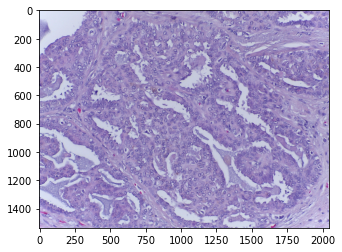

In [21]:
pic = Image.open(train_set[0])
plt.figure()
plt.imshow(pic)

In [24]:
pic = np.array(pic)
pic.shape

(1536, 2048, 3)

In [17]:
def resize_pil(pil_list, size):
    return [img.resize(size) for img in pil_list]

In [18]:
def get_label(file_name):
    if 'Benign' in file_name:
        return 0
    elif 'InSitu' in file_name:
        return 1
    elif 'Invasive' in file_name:
        return 2
    elif 'Normal' in file_name:
        return 3

In [19]:
def parse_files_set(files_set, mode='single', crop_size=(700,700), resize_size=(150,150)):
    
    modes = {
        'single': (center_crop, 1),
        'five' : (five_crop, 5),
        'ten' : (ten_crop, 10)
    }
    
    croper, multiplier = modes[mode]
    
    X = []
    y = []
    
    for f in tqdm(files_set):
        img = Image.open(f)
        imgs = croper(img, crop_size)
        
        if mode is not 'single':
            imgs = resize_pil(imgs, resize_size)
            np_imgs = [np.array(pic) for pic in imgs]
            X.extend(np_imgs)
            y.extend(multiplier * [get_label(f)])
        else:
            imgs = imgs.resize(resize_size)
            np_imgs = np.array(imgs)
            X.append(np_imgs)
            y.append(get_label(f))
    
    X = np.array(X).astype('float32') / 255
    y = np.asarray(y, dtype='uint8')
    
    return X, y

In [17]:
mode = 'five'
X_train, y_train = parse_files_set(train_set, mode=mode)
X_test, y_test = parse_files_set(test_set, mode=mode)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

100%|██████████| 80/80 [00:02<00:00, 26.77it/s]


((1600, 150, 150, 3), (1600,), (400, 150, 150, 3), (400,))

In [18]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [19]:
X_train[0], X_test[0]

(array([[[0.8745098 , 0.6039216 , 0.9607843 ],
         [0.8235294 , 0.5882353 , 0.99215686],
         [0.89411765, 0.6509804 , 0.99215686],
         ...,
         [0.9843137 , 0.73333335, 0.99215686],
         [0.83137256, 0.6       , 1.        ],
         [0.7607843 , 0.59607846, 1.        ]],
 
        [[0.8980392 , 0.64705884, 1.        ],
         [0.8392157 , 0.64705884, 1.        ],
         [0.89411765, 0.65882355, 1.        ],
         ...,
         [0.9411765 , 0.73333335, 0.9882353 ],
         [0.9764706 , 0.8       , 0.99607843],
         [0.8039216 , 0.62352943, 0.9882353 ]],
 
        [[0.7176471 , 0.5058824 , 0.9411765 ],
         [0.7607843 , 0.5411765 , 0.9764706 ],
         [0.72156864, 0.56078434, 0.94509804],
         ...,
         [0.9843137 , 0.75686276, 0.99215686],
         [0.8862745 , 0.65882355, 0.9882353 ],
         [0.9411765 , 0.7607843 , 0.99607843]],
 
        ...,
 
        [[0.9411765 , 0.6862745 , 1.        ],
         [0.6862745 , 0.43137255, 0.82745

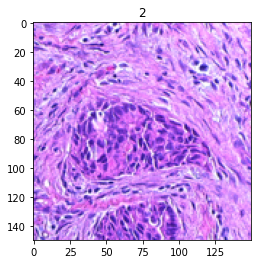

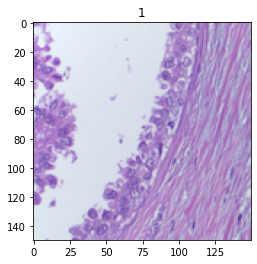

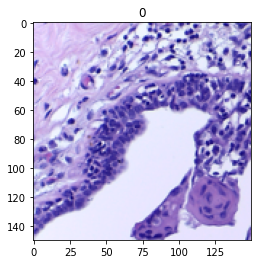

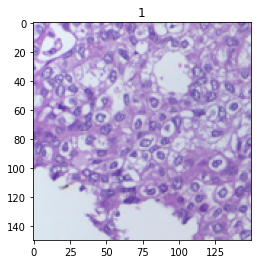

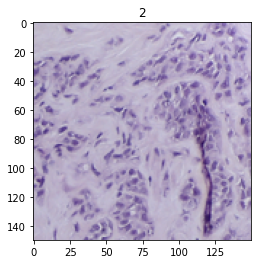

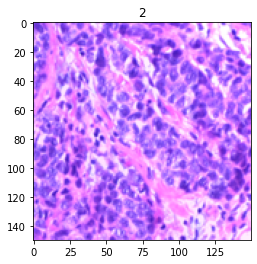

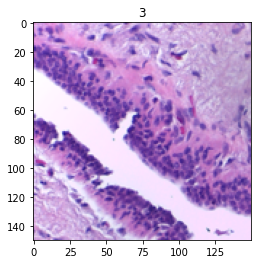

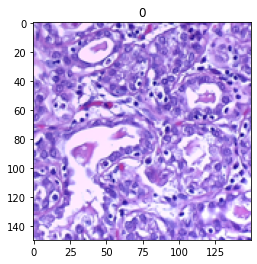

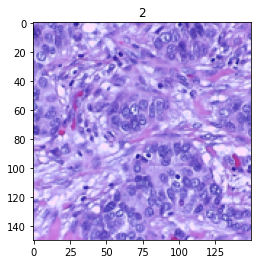

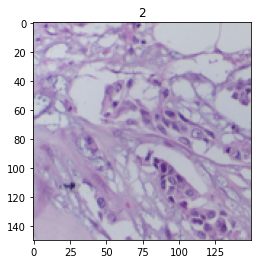

In [20]:
for i in range(10):
    plt.figure()
    plt.imshow(X_train[i])
    plt.title(y_train[i])

### Save to npy files

In [21]:
base_path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/iciar/'
path_format = base_path + '{}'
p = Path(base_path)
p.mkdir(parents=True, exist_ok=True)

In [22]:
mode = 'ten'
X_train, y_train = parse_files_set(train_set, mode=mode)
X_test, y_test = parse_files_set(test_set, mode=mode)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

np.save(path_format.format('X_train_ten'), X_train)
np.save(path_format.format('y_train_ten'), y_train)
np.save(path_format.format('X_test_ten'), X_test)
np.save(path_format.format('y_test_ten'), y_test)

100%|██████████| 80/80 [00:05<00:00, 14.24it/s]


In [23]:
mode = 'five'
X_train, y_train = parse_files_set(train_set, mode=mode)
X_test, y_test = parse_files_set(test_set, mode=mode)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

np.save(path_format.format('X_train_five'), X_train)
np.save(path_format.format('y_train_five'), y_train)
np.save(path_format.format('X_test_five'), X_test)
np.save(path_format.format('y_test_five'), y_test)

100%|██████████| 80/80 [00:03<00:00, 24.21it/s]


In [24]:
mode = 'single'
X_train, y_train = parse_files_set(train_set, mode=mode)
X_test, y_test = parse_files_set(test_set, mode=mode)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

np.save(path_format.format('X_train_single'), X_train)
np.save(path_format.format('y_train_single'), y_train)
np.save(path_format.format('X_test_single'), X_test)
np.save(path_format.format('y_test_single'), y_test)

100%|██████████| 80/80 [00:01<00:00, 51.30it/s]


In [25]:
def load_iciar(mode):
    assert mode in ['single', 'five', 'ten']
    
    path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/iciar/'
    
    x_train_file = 'X_train_{}.npy'.format(mode)
    y_train_file = 'y_train_{}.npy'.format(mode)    
    x_test_file = 'X_test_{}.npy'.format(mode)  
    y_test_file = 'y_test_{}.npy'.format(mode)
    
    X_train = np.load(path + x_train_file)
    y_train = np.load(path + y_train_file)
    X_test = np.load(path + x_test_file)
    y_test = np.load(path + y_test_file)
    
    return (X_train, y_train), (X_test, y_test)

In [41]:
(X_train, y_train), (X_test, y_test) = load_iciar('single')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320, 150, 150, 3), (320,), (80, 150, 150, 3), (80,))

In [42]:
(X_train, y_train), (X_test, y_test) = load_iciar('five')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1600, 150, 150, 3), (1600,), (400, 150, 150, 3), (400,))

In [43]:
(X_train, y_train), (X_test, y_test) = load_iciar('ten')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3200, 150, 150, 3), (3200,), (800, 150, 150, 3), (800,))

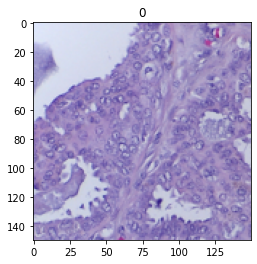

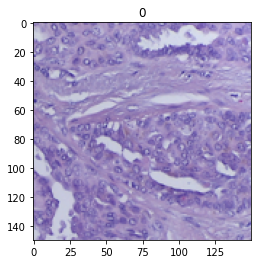

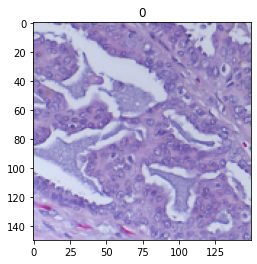

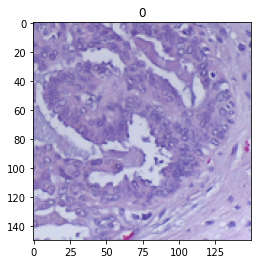

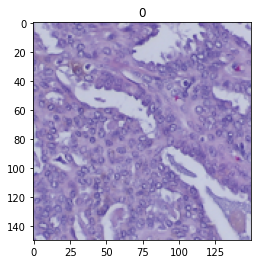

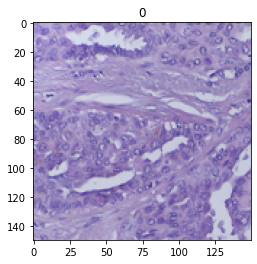

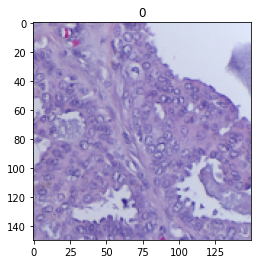

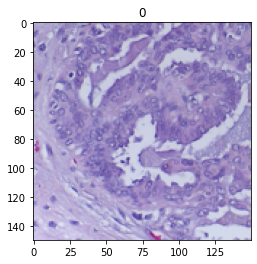

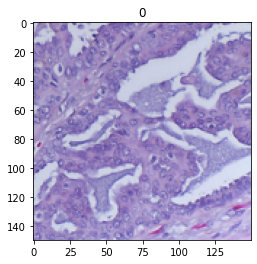

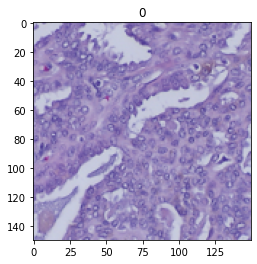

In [39]:
for i in range(10):
    plt.figure()
    plt.imshow(X_train[i])
    plt.title(y_train[i])

In [40]:
X_train[0]

array([[[0.8784314 , 0.9019608 , 0.9882353 ],
        [0.8745098 , 0.9098039 , 0.9764706 ],
        [0.8745098 , 0.90588236, 0.98039216],
        ...,
        [0.6392157 , 0.6039216 , 0.76862746],
        [0.64705884, 0.627451  , 0.77254903],
        [0.6392157 , 0.61960787, 0.7607843 ]],

       [[0.8784314 , 0.9098039 , 0.972549  ],
        [0.88235295, 0.9137255 , 0.98039216],
        [0.8784314 , 0.9098039 , 0.9882353 ],
        ...,
        [0.627451  , 0.5686275 , 0.7607843 ],
        [0.6156863 , 0.5764706 , 0.76862746],
        [0.63529414, 0.6       , 0.7764706 ]],

       [[0.8784314 , 0.8980392 , 0.972549  ],
        [0.87058824, 0.90588236, 0.9764706 ],
        [0.8745098 , 0.9098039 , 0.99215686],
        ...,
        [0.5882353 , 0.5176471 , 0.73333335],
        [0.5882353 , 0.5254902 , 0.7411765 ],
        [0.5882353 , 0.52156866, 0.7372549 ]],

       ...,

       [[0.58431375, 0.5372549 , 0.7490196 ],
        [0.6       , 0.5411765 , 0.7294118 ],
        [0.7607843 , 0